In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# This notebook is written with the help of ChatGPT (June 2025) and verified by L. Perez.

In [2]:
df = pd.read_csv("data/all_models_metrics_for_paper.csv").fillna("")

In [3]:
# Add the number total of simple and correct verses to the dataset

# Define mappings
simple_map = {
    1000: 890,
    2616: 2327,
    200: 178
}

complex_map = {
    1000: 110,
    2616: 289,
    200: 22
}

# Apply mappings to create new columns
df["total_simple_verses"] = df["total_verses"].map(simple_map)
df["total_complex_verses"] = df["total_verses"].map(complex_map)

In [4]:
df.columns

Index(['model', 'dataset_size', 'temperature', 'fine_tuned', 'total_clauses',
       'total_found', 'total_cut_clauses', 'total_embedded', 'found_embedded',
       'total_non_embedded', 'found_non_embedded', 'found_cut_clauses',
       'total_other_clauses', 'found_other_clauses', 'total_non_cut_clauses',
       'found_non_cut_clauses', 'total_verses', 'correct_verses',
       'simple_correct', 'complex_correct', 'total_simple_clauses',
       'total_simple_found', 'total_complex_clauses', 'total_complex_found',
       'total_simple_verses', 'total_complex_verses'],
      dtype='object')

In [5]:
df[df.model == "GPT-4o mini"]

,model,dataset_size,temperature,fine_tuned,total_clauses,total_found,total_cut_clauses,total_embedded,found_embedded,total_non_embedded,...,total_verses,correct_verses,simple_correct,complex_correct,total_simple_clauses,total_simple_found,total_complex_clauses,total_complex_found,total_simple_verses,total_complex_verses
0,GPT-4o mini,medium,0,no,3827,1444,114,127,7,3700,...,1000,209,209,0,3301,1350,526,94,890,110
1,GPT-4o mini,large,0,no,10204,3818,306,341,18,9858,...,2616,527,527,0,8805,3560,1399,258,2327,289
2,GPT-4o mini,small,0,no,779,299,22,24,1,755,...,200,37,37,0,685,282,94,17,178,22
6,GPT-4o mini,large,0,yes,10204,8662,306,341,205,9858,...,2616,1830,1739,91,8805,7687,1399,975,2327,289
7,GPT-4o mini,medium,0,yes,3827,3025,114,127,58,3700,...,1000,611,589,22,3301,2707,526,318,890,110
8,GPT-4o mini,small,0,yes,779,554,22,24,3,755,...,200,96,96,0,685,514,94,40,178,22
9,GPT-4o mini,large,1,yes,10204,8496,306,341,204,9858,...,2616,1739,1650,89,8805,7542,1399,954,2327,289
10,GPT-4o mini,medium,1,yes,3827,2987,114,127,59,3700,...,1000,590,571,19,3301,2676,526,311,890,110


In [6]:
# Adding the modle_temp column to identify trials (model + temperature)

df_filtered = df.copy()
df_filtered["model_temp"] = (
    df_filtered["model"] + 
    " (T=" + df_filtered["temperature"].astype(str) + 
    ", " + df_filtered["fine_tuned"].map({"yes": "ft", "no": "base"}) + ")"
)

# Uncomment these two lines to filter the df_filtered (e.g. with only base or fine tuned models)

#df_filtered = df[df["fine_tuned"] == "no"].copy()
#df_filtered["model_temp"] = df_filtered["model"] + " (T=" + df_filtered["temperature"].astype(str) + ")" 

In [10]:
set(df_filtered.model_temp)

{'GPT-4o (T=0, base)',
 'GPT-4o (T=0, ft)',
 'GPT-4o mini (T=0, base)',
 'GPT-4o mini (T=0, ft)',
 'GPT-4o mini (T=1, ft)'}

In [11]:
# Create accuracy columns
df_filtered["acc_total_clauses"] = df_filtered["total_found"] / df_filtered["total_clauses"]
df_filtered["acc_embedded"] = df_filtered["found_embedded"] / df_filtered["total_embedded"]
df_filtered["acc_non_embedded"] = df_filtered["found_non_embedded"] / df_filtered["total_non_embedded"]
df_filtered["acc_cut"] = df_filtered["found_cut_clauses"] / df_filtered["total_cut_clauses"]
df_filtered["acc_other"] = df_filtered["found_other_clauses"] / df_filtered["total_other_clauses"]

df_filtered["acc_total_verses"] = df_filtered["correct_verses"] / df_filtered["total_verses"]
df_filtered["acc_simple_verses"] = df_filtered["simple_correct"] / df_filtered["total_simple_verses"]
df_filtered["acc_complex_verses"] = df_filtered["complex_correct"] / df_filtered["total_complex_verses"]

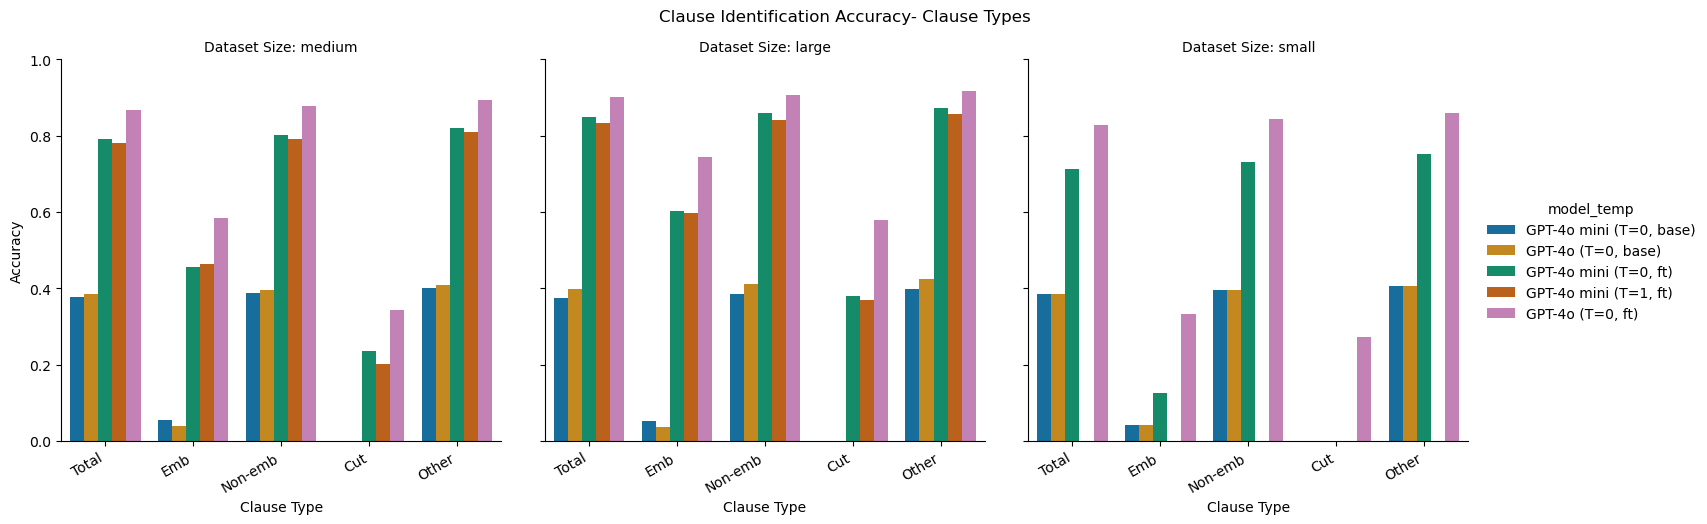

In [12]:
# CLAUSE IDENTIFICATION BASED ON VERSE TYPE
plot_df = df_filtered[[
    "dataset_size", "model_temp", "acc_total_clauses", "acc_embedded", "acc_non_embedded", "acc_cut", "acc_other"
]]
plot_df_melted = plot_df.melt(id_vars=["dataset_size", "model_temp"], 
                              var_name="Clause Type", 
                              value_name="Accuracy")

plot_df_melted["Clause Type"] = plot_df_melted["Clause Type"].map({
    "acc_total_clauses": "Total",
    "acc_embedded": "Emb",
    "acc_non_embedded": "Non-emb",
    "acc_cut": "Cut",
    "acc_other": "Simple"
})

# Use facet by dataset size
g = sns.catplot(
    data=plot_df_melted, x="Clause Type", y="Accuracy", hue="model_temp", 
    col="dataset_size", kind="bar", palette="colorblind", height=5, aspect=1 # aspect reduces the bar width
)
g.set_titles("Dataset Size: {col_name}")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.85)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right") # this rotate the x axis labels

g.fig.subplots_adjust(top=0.88, wspace=0.1) # this reduces the margin and whitespaces

g.fig.suptitle("Clause Identification Accuracy- Clause Types")


plt.show()

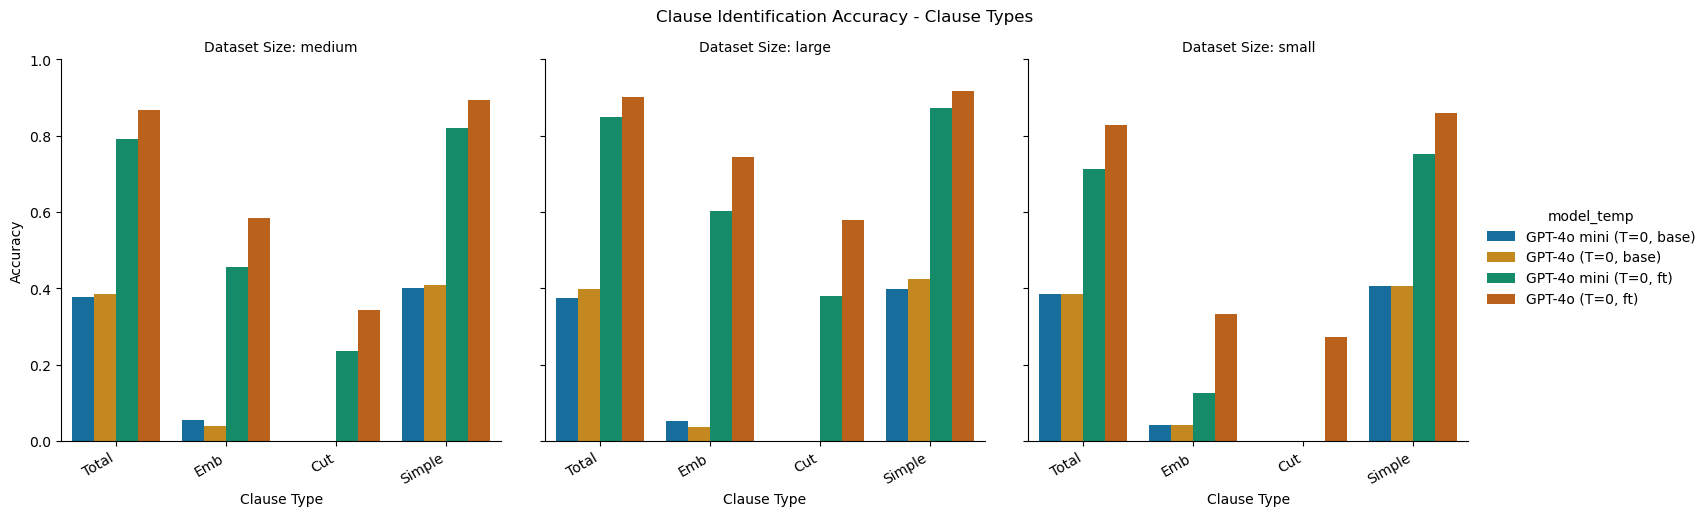

In [13]:
# CLAUSE IDENTIFICATION BASED ON CLAUSE TYPE
plot_df = df_filtered[[
    "dataset_size", "model_temp", "acc_total_clauses", "acc_embedded", "acc_non_embedded", "acc_cut", "acc_other"
]]
plot_df_melted = plot_df.melt(id_vars=["dataset_size", "model_temp"], 
                              var_name="Clause Type", 
                              value_name="Accuracy")

plot_df_melted["Clause Type"] = plot_df_melted["Clause Type"].map({
    "acc_total_clauses": "Total",
    "acc_embedded": "Emb",
    #"acc_non_embedded": "Non-emb",
    "acc_cut": "Cut",
    "acc_other": "Simple"
})

plot_df_melted = plot_df_melted[plot_df_melted["model_temp"] != "GPT-4o mini (T=1, ft)"] # excludes the gpt 4o mini with missing data

# Use facet by dataset size
g = sns.catplot(
    data=plot_df_melted, x="Clause Type", y="Accuracy", hue="model_temp", 
    col="dataset_size", kind="bar", palette="colorblind", height=5, aspect=1 # aspect reduces the bar width
)
g.set_titles("Dataset Size: {col_name}")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.85)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right") # this rotate the x axis labels

g.fig.subplots_adjust(top=0.88, wspace=0.1) # this reduces the margin and whitespaces

g.fig.suptitle("Clause Identification Accuracy - Clause Types")


plt.show()

In [22]:
g.savefig("figures/clause_type_acc_most_models.png", dpi=300, bbox_inches='tight')

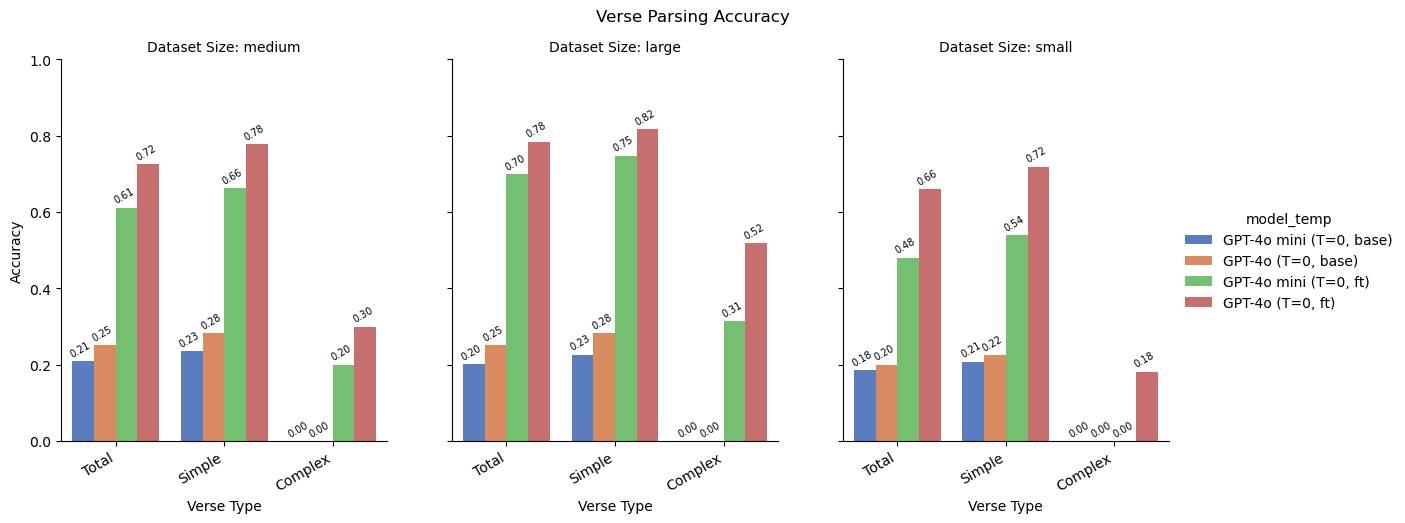

In [14]:
# Accuracy for verses parsing
plot_df = df_filtered[[
    "dataset_size", "model_temp", "acc_total_verses", "acc_simple_verses", "acc_complex_verses"
]]
plot_df_melted = plot_df.melt(id_vars=["dataset_size", "model_temp"], 
                              var_name="Verse Type", 
                              value_name="Accuracy")

plot_df_melted["Verse Type"] = plot_df_melted["Verse Type"].map({
    "acc_total_verses": "Total",
    "acc_simple_verses": "Simple",
    "acc_complex_verses": "Complex"
})

plot_df_melted = plot_df_melted[plot_df_melted["model_temp"] != "GPT-4o mini (T=1, ft)"] # excludes the gpt 4o mini with missing data

# Use facet by dataset size
g = sns.catplot(
    data=plot_df_melted, x="Verse Type", y="Accuracy", hue="model_temp", 
    col="dataset_size", kind="bar", palette="muted", height=5, aspect=0.8 # aspect reduces the bar width
)
g.set_titles("Dataset Size: {col_name}")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.85)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right") # this rotate the x axis labels

g.fig.subplots_adjust(top=0.88, wspace=0.2) # this reduces the margin and whitespaces

g.fig.suptitle("Verse Parsing Accuracy")

# Annotate bars with rotated percentage values
for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=7,
                    rotation=30,  # twist
                    rotation_mode='anchor'
                )


plt.show()

In [25]:
g.savefig("figures/verses_parsing_acc_most_models.png", dpi=300, bbox_inches='tight')

In [12]:
# Analysing fine-tuned models 

df_fine_tuned = df[df["fine_tuned"] == "yes"].copy()
df_fine_tuned["model_temp"] = df_fine_tuned["model"] + " (T=" + df_fine_tuned["temperature"].astype(str) + ")"

In [13]:
# Create accuracy columns
df_fine_tuned["acc_total_clauses"] = df_fine_tuned["total_found"] / df_fine_tuned["total_clauses"]
df_fine_tuned["acc_embedded"] = df_fine_tuned["found_embedded"] / df_fine_tuned["total_embedded"]
df_fine_tuned["acc_non_embedded"] = df_fine_tuned["found_non_embedded"] / df_fine_tuned["total_non_embedded"]
df_fine_tuned["acc_cut"] = df_fine_tuned["found_cut_clauses"] / df_fine_tuned["total_cut_clauses"]
df_fine_tuned["acc_other"] = df_fine_tuned["found_other_clauses"] / df_fine_tuned["total_other_clauses"]

df_fine_tuned["acc_total_verses"] = df_fine_tuned["correct_verses"] / df_fine_tuned["total_verses"]
df_fine_tuned["acc_simple_verses"] = df_fine_tuned["simple_correct"] / df_fine_tuned["total_simple_verses"]
df_fine_tuned["acc_complex_verses"] = df_fine_tuned["complex_correct"] / df_fine_tuned["total_complex_verses"]

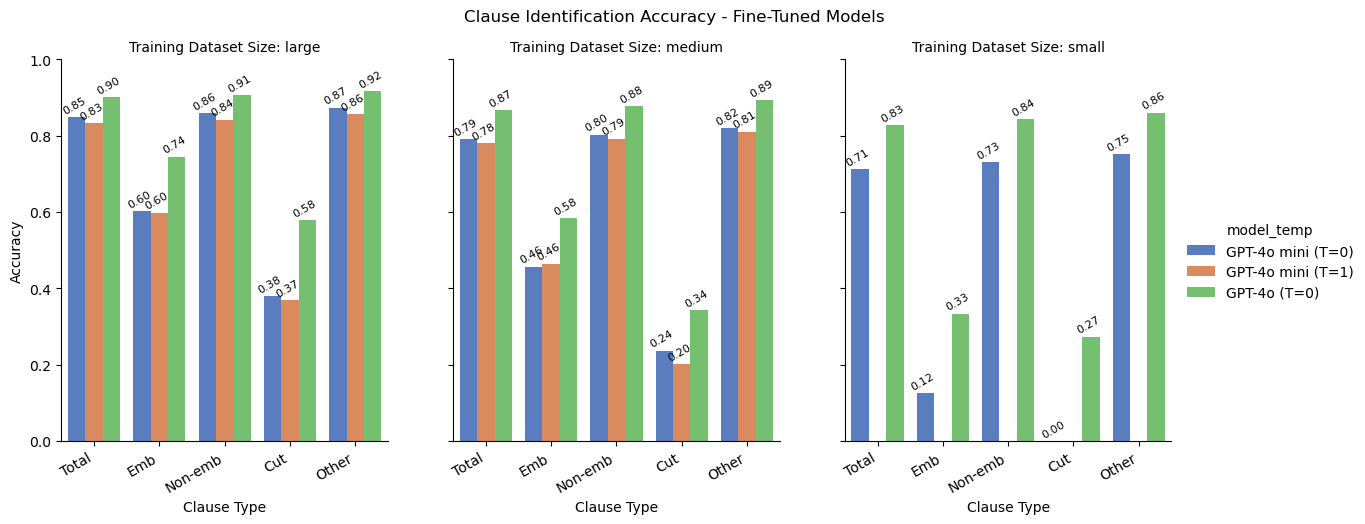

In [59]:
# Clause identification accuracy - fine_tuned models
plot_df = df_fine_tuned[[
    "dataset_size", "model_temp", "acc_total_clauses", "acc_embedded", "acc_non_embedded", "acc_cut", "acc_other"
]]
plot_df_melted = plot_df.melt(id_vars=["dataset_size", "model_temp"], 
                              var_name="Clause Type", 
                              value_name="Accuracy")

plot_df_melted["Clause Type"] = plot_df_melted["Clause Type"].map({
    "acc_total_clauses": "Total",
    "acc_embedded": "Emb",
    "acc_non_embedded": "Non-emb",
    "acc_cut": "Cut",
    "acc_other": "Other"
})

# Use facet by dataset size
g = sns.catplot(
    data=plot_df_melted, x="Clause Type", y="Accuracy", hue="model_temp", 
    col="dataset_size", kind="bar", palette="muted", height=5, aspect=0.8
)
g.set_titles("Training Dataset Size: {col_name}")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.85)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right") # this rotate the x axis labels

g.fig.subplots_adjust(top=0.88, wspace=0.2) # this reduces the margin and whitespaces

g.fig.suptitle("Clause Identification Accuracy - Fine-Tuned Models")
# Annotate bars with rotated percentage values
for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    rotation=30,  # twist
                    rotation_mode='anchor'
                )


plt.show()

In [60]:
g.savefig("figures/clause_identification_acc_fine_tuned_models.png", dpi=300, bbox_inches='tight')

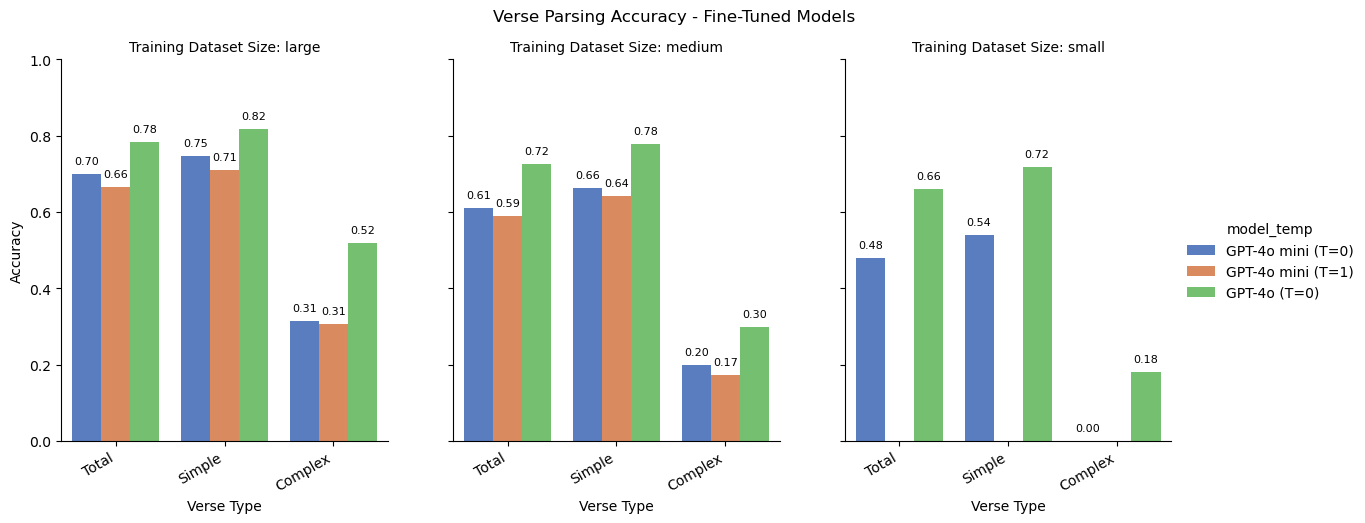

In [53]:
# Accuracy for verses parsing - fined-tuned models
plot_df = df_fine_tuned[[
    "dataset_size", "model_temp", "acc_total_verses", "acc_simple_verses", "acc_complex_verses"
]]
plot_df_melted = plot_df.melt(id_vars=["dataset_size", "model_temp"], 
                              var_name="Verse Type", 
                              value_name="Accuracy")

plot_df_melted["Verse Type"] = plot_df_melted["Verse Type"].map({
    "acc_total_verses": "Total",
    "acc_simple_verses": "Simple",
    "acc_complex_verses": "Complex"
})

# Use facet by dataset size
g = sns.catplot(
    data=plot_df_melted, x="Verse Type", y="Accuracy", hue="model_temp", 
    col="dataset_size", kind="bar", palette="muted", height=5, aspect=0.8 # aspect reduces the bar width
)
g.set_titles("Training Dataset Size: {col_name}")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.85)            

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right") # this rotate the x axis labels

g.fig.subplots_adjust(top=0.88, wspace=0.2) # this reduces the margin and whitespaces

g.fig.suptitle("Verse Parsing Accuracy - Fine-Tuned Models")

for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                   # rotation=30,  # twist
                    rotation_mode='anchor'
                )

plt.show()

In [54]:
g.savefig("figures/verses_parsing_acc_fine_tuned_models.png", dpi=300, bbox_inches='tight')

In [18]:
# Visualisation for input/output consistency from manual data

In [18]:
df_input_output = pd.read_csv("data/input_output_consistency.csv").fillna("")
df_input_output.columns

Index(['model', 'temperature', 'fine_tuned', 'training_dataset_size',
       'percentage_exact_restitution', 'percentage_exact_words_restitution'],
      dtype='object')

In [19]:
df_input_output = df_input_output.copy()
df_input_output["model_temp"] = (
    df_input_output["model"] + 
    " (T=" + df_input_output["temperature"].astype(str) + 
    ", " + df_input_output["fine_tuned"].map({"yes": "ft", "no": "base"}) + ")"
)

In [20]:
df_input_output.head()

,model,temperature,fine_tuned,training_dataset_size,percentage_exact_restitution,percentage_exact_words_restitution,model_temp
0,GPT-4o,0,yes,small,94.500000,99.00000,"GPT-4o (T=0, ft)"
1,GPT-4o,0,yes,medium,92.300000,99.20000,"GPT-4o (T=0, ft)"
2,GPT-4o,0,yes,large,89.067278,98.96789,"GPT-4o (T=0, ft)"
3,GPT-4o mini,0,yes,small,95.000000,99.00000,"GPT-4o mini (T=0, ft)"
4,GPT-4o mini,0,yes,medium,94.400000,98.90000,"GPT-4o mini (T=0, ft)"


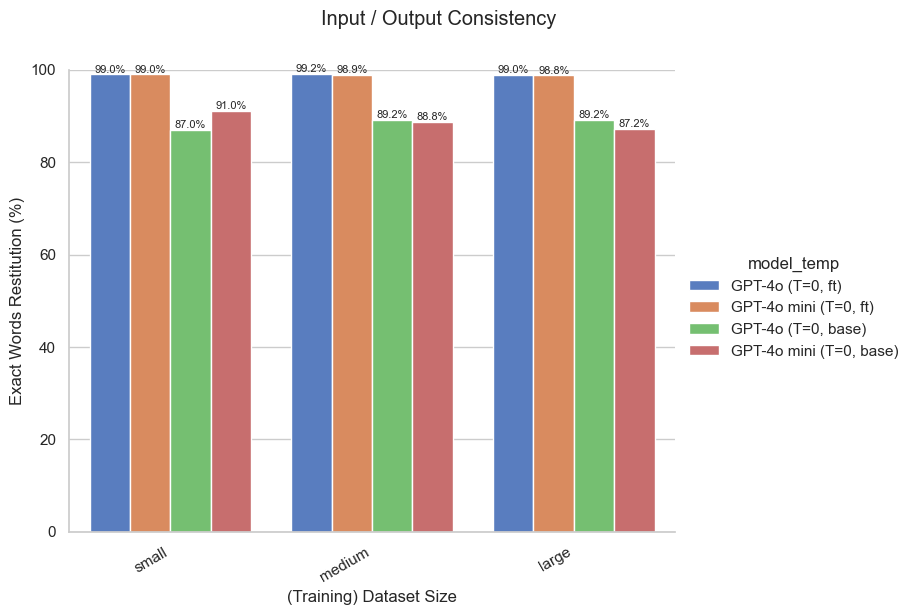

In [38]:
# Prepare data for plotting
# Prepare the data with only one metric
plot_df = df_input_output[[
    "training_dataset_size", "model_temp", "percentage_exact_words_restitution"
]]

# Use catplot for easy faceting and .axes.flat access
g = sns.catplot(
    data=plot_df,
    x="training_dataset_size",
    y="percentage_exact_words_restitution",
    hue="model_temp",
    kind="bar",
    palette="muted",
    height=6,
    aspect=1.2
)

# Set general appearance
g.set_axis_labels("(Training) Dataset Size", "Exact Words Restitution (%)")
g.set(ylim=(0, 100))
g.fig.subplots_adjust(top=0.88, right=0.75)  # Adjust top + leave space on right for legend
g.fig.suptitle("Input / Output Consistency")

# Rotate x-axis labels and add value labels on bars
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.1f}%",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    rotation_mode='anchor'
                )

plt.show()

In [39]:
g.savefig("figures/input_output_consistency_by_model_and_size_words.png", dpi=300, bbox_inches='tight')